# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
#Boro City 2010 is the census tract file
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
#Just checking that everything appears to make sense. 
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

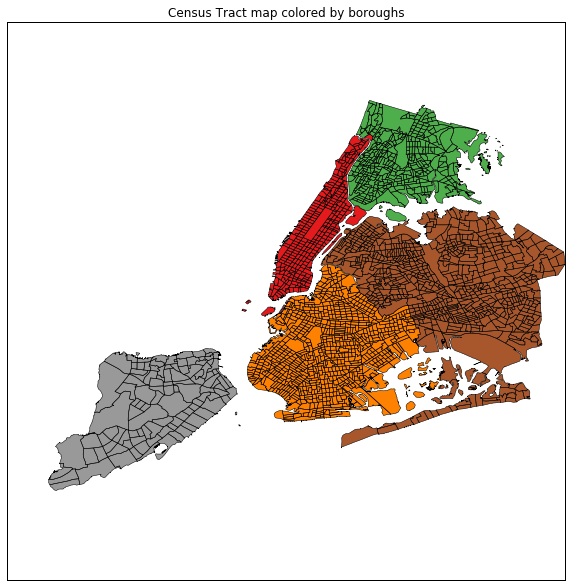

In [5]:
#Heat map to correspond to the boro column. Colors are random, corresponding to Boro value. 
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

<b>Figure 1:</b> Census tracts colored by borough across New York City

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
#Don't need to specify indicies because 'join' auto searches for it and matches the two datasets based on the 
#indicies in common.
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


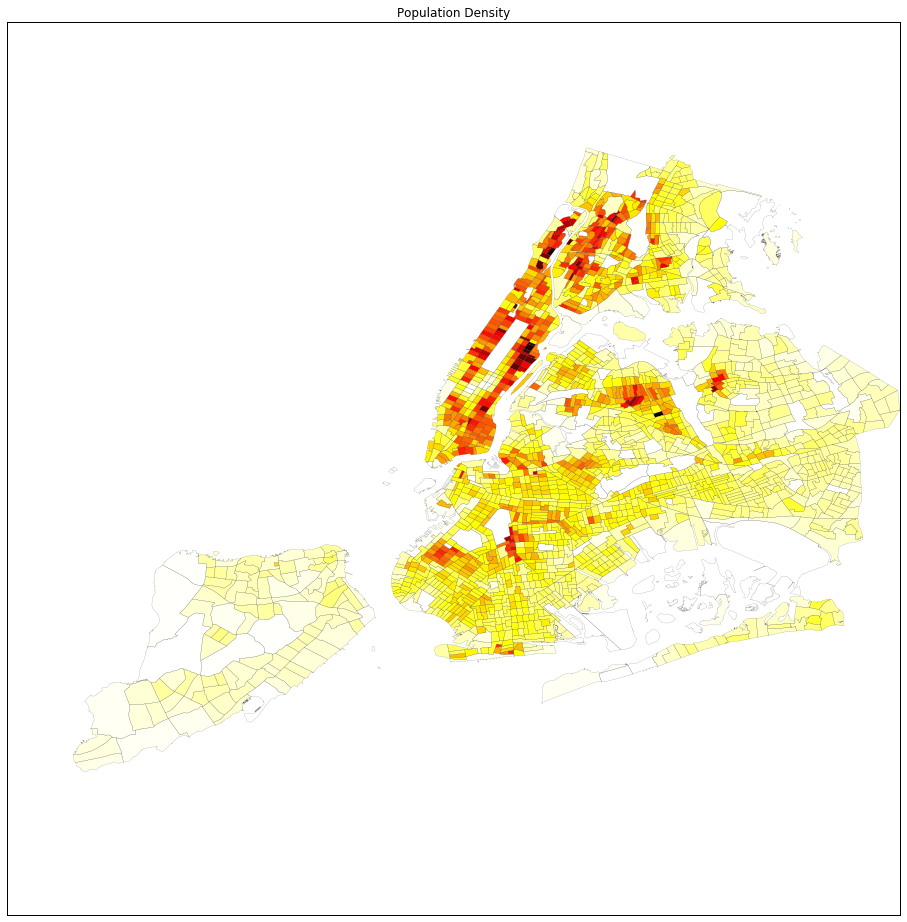

In [8]:
f, ax = plt.subplots(figsize=(16,16))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

<b>Figure 2:</b> Visualization of New York City's population density. Darker colors and reds indicate higher concentrations of population density.

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Analysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

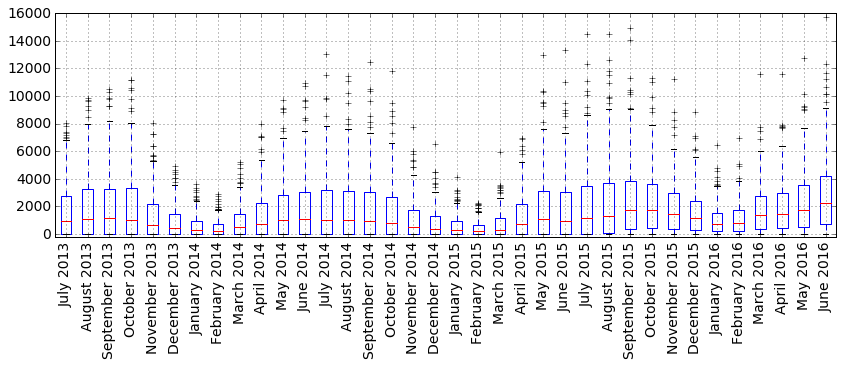

In [10]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

<b>Figure 3: </b>Time series analysis of Citibike rides showing clear periodicity and seasonality of ridership. 

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


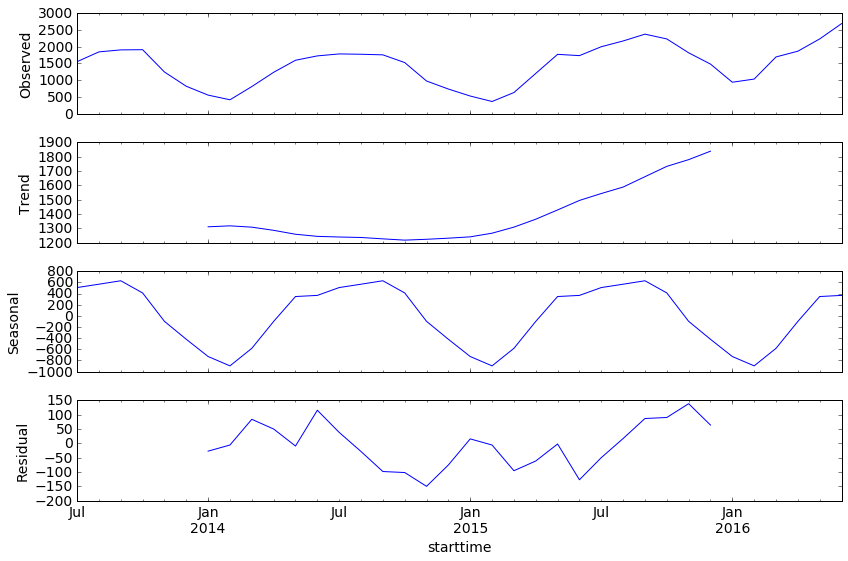

In [11]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

<b>Figure 4: </b> Seasonal decomposition of Citibike rides from July 2013 to July 2016.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [12]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [13]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [14]:
a=[]
# check for each citibike stations to see what CT they are belong to
# stations will belong to one tract or another... there is no overlap. Sites on a line
# belong to one tract or the other. That's what the intersects do. 
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [15]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [16]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.mean() #changed this from .sum() to .mean()... .sum() did not appear to make
                                                #sense if we were seeking the averages on a monthly basis. 

In [17]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1925.222222
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,2856.222222
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,7597.916667
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,2831.916667
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,5112.333333


### Add the monthly average rides to the CT shapefile 

In [18]:
temp=station_id[['MonthlyAve']] #Monthly Average
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010'] #City boro census tract
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1925.222222
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,2856.222222
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,7597.916667
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,2831.916667
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,5112.333333


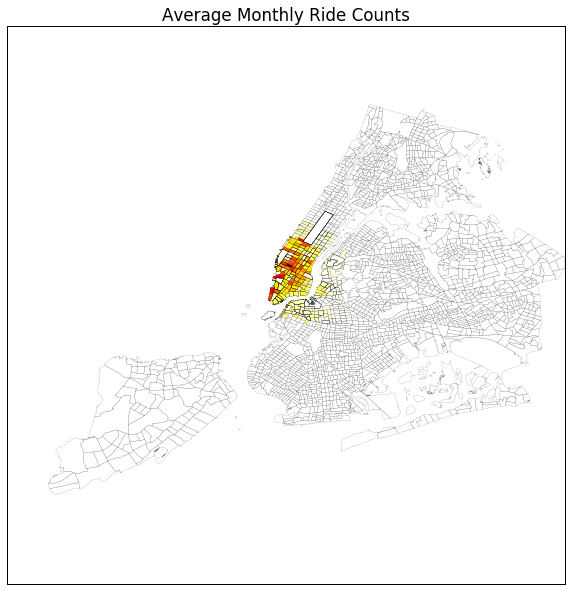

In [20]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#MonthlyAve is an average of all months.
plt.title("Average Monthly Ride Counts")

<b>Figure 5: </b>Heat map showing concentration of average ride counts by census tract from July 2013 to July 2016. Citibike stations are only available in certain census tracts and neighborhoods at present, which is why there are so many blank census tracts. Darker colored tracts have a higher average concentration of rides over the three year period.

### Removing the CTs that are out of zoom boundries

In [21]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

#Setting lat/long boundaries based on map above. 

In [22]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

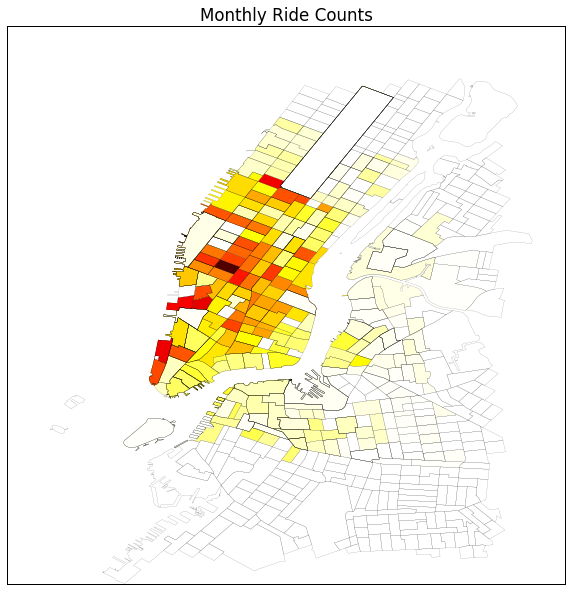

In [23]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

<b>Figure 6: </b> Zoomed map showing portion of New York City that has Citibike stations and the average number of rides per census tract from July 2013 to July 2016.

### Export Shapefile CTs in the CitiBike Zone

In [24]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [25]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [26]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [27]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [28]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [29]:
Wmatrix, ids = qW_CT.full()

In [30]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [31]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neighbors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [32]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [33]:
#Quantile... think quartile, but not constrained to 4. 
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               140
   0.000 < x[i] <=    6.599                21
   6.599 < x[i] <=  115.766                78
 115.766 < x[i] <=  278.524                80
 278.524 < x[i] <=  485.928                79
 485.928 < x[i] <=  749.363                80
 749.363 < x[i] <= 1614.619                79
1614.619 < x[i] <= 2271.890                80
2271.890 < x[i] <= 2690.834                79
2690.834 < x[i] <= 4221.760                80

In [34]:
#Zoom helps fix up 0 count above... it woudl otherwise be tremendously skewed. 

#### Map the monthly rides lag

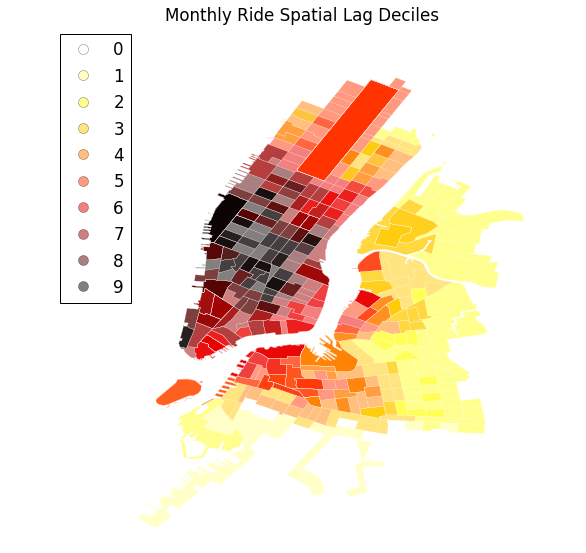

In [35]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")


<b>Figure 7: </b>Map above visualizes spatial lag deciles from July 2013 to July 2016. Spatial lag assumes a dependency or relationship between a given census tract and the tracts directly adjacent to it as a direct result of proximity. Deciles and coloration reflect each census tract's average for all adjacent census tracts.

## Global  Spatial Autocorrelation

In [36]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948478, 348.82325173299694)

### Moran Scatterplot

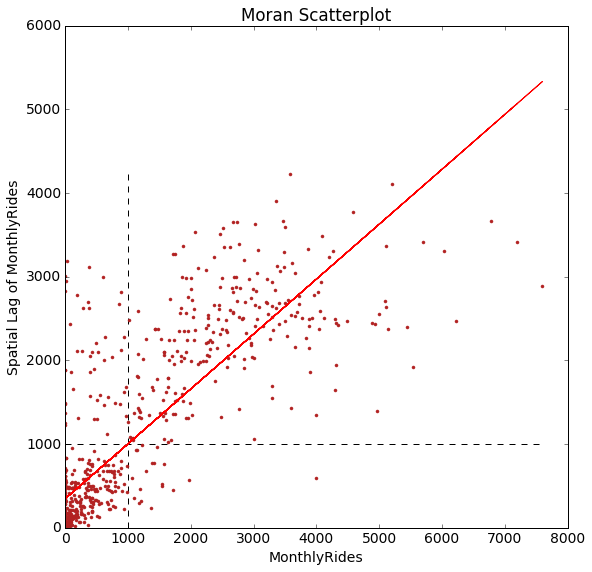

In [37]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

<b>Figure 8: </b>The Moran Scatter Plot above assesses the similarity between observed rides in each season relative to the spatial lag in that same season.

### Moran's I

In [38]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [39]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

#second number, after the comma, is a P-Value indicating the significance of the line above. 

(0.65579332908409083, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [40]:
I_MonthlyRide.sim[0:10]

array([-0.00888171, -0.01222682, -0.02079244, -0.00483308,  0.00092683,
        0.00951394, -0.00332975, -0.02626399, -0.004756  , -0.01757056])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [41]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

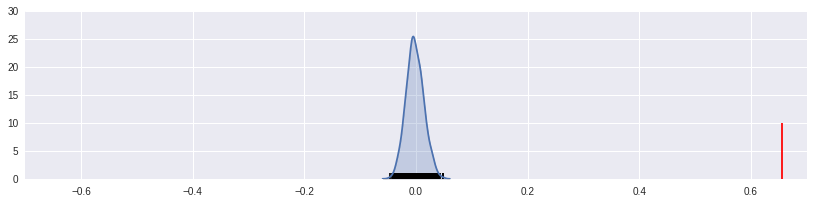

In [42]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

<b>Figure 9: </b>Kernal Density Estimation plot of rides from July 2013 - July 2016. The red line on the right-hand side shows the observed value. 

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

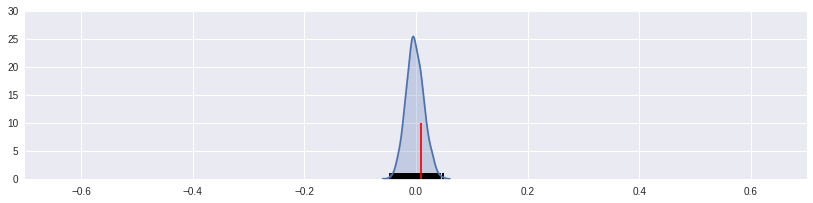

In [43]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

<b>Figure 10:</b> Kernal Density Estimation plot of rides from July 2013 - July 2016. The red line shows whether our $I$ statistic is close to our expected value. 

## Local  Spatial Autocorrelation

In [44]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [45]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.18 ,  0.406,  0.388,  0.449]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [46]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

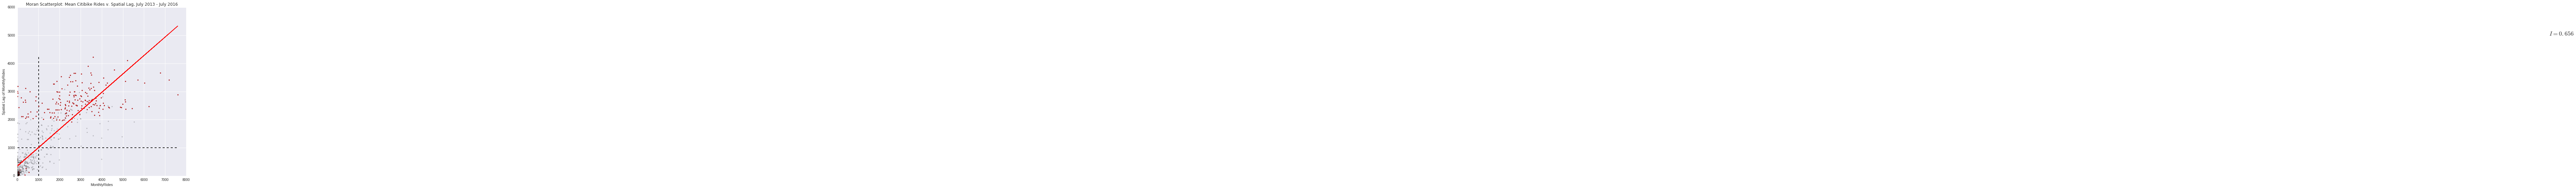

In [47]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot: Mean Citibike Rides v. Spatial Lag, July 2013 - July 2016')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

<b>Figure 11: </b> Moran Scatter Plot showing spatial lag relative to mean rides. Grey points represent stations without significant spatial autocorrelation; red points represent stations with significant spatial autocorrelation.

### Hot and Cold spots 

In [48]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print ("Number of Hotspots:", hotspots.sum())
print ("Number of Coldspots:", coldspots.sum())

('Number of Hotspots:', 191)
('Number of Coldspots:', 233)


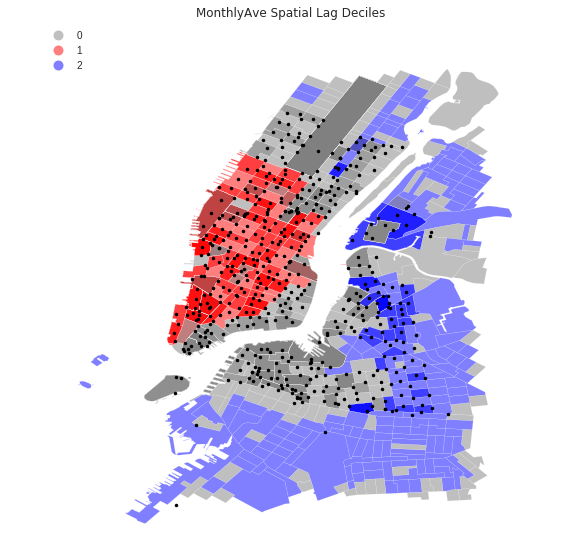

In [49]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")
ax.plot(station_id['lon'], station_id['lat'], '.', color = 'k')

<b>Figure 12: </b> Map above shows spatial autocorrelation in terms of a heat map. Black dots represent the locations of stations across the city. Red clusters are "hot spots" and show high spatial correlation between census tracts, with high mean ridership at the stations in those areas. Blue clusters are cold spots, with mean ridership in those clusters low. Many of the blue census tracts in fact lack stations at all. Grey districts show no spatial autocorrelation and relative neutrality in terms of popularity and mean riderhsip.